In [17]:
import pandas as pd
from darts import TimeSeries
import numpy as np

In [1]:


# Read a pandas DataFrame
df = pd.read_csv('AirPassengers.csv', delimiter=",")

# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(df, 'Month', '#Passengers')

# Set aside the last 36 months as a validation series
train, val = series[:-36], series[-36:]

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [3]:
from darts.models import ExponentialSmoothing

model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val), num_samples=1000)

[2022-06-12 17:54:57,607] WARNING | darts.models | Support for Facebook Prophet is not available. To enable it, install "darts", "u8darts[prophet]" or "u8darts[all]" (with pip);or "u8darts-all" (with conda).
2022-06-12 17:54:57 darts.models WARNING: Support for Facebook Prophet is not available. To enable it, install "darts", "u8darts[prophet]" or "u8darts[all]" (with pip);or "u8darts-all" (with conda).


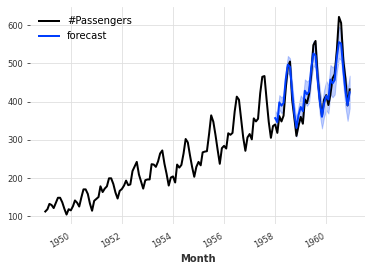

In [4]:
import matplotlib.pyplot as plt

series.plot()
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

#### Splitting timeseries

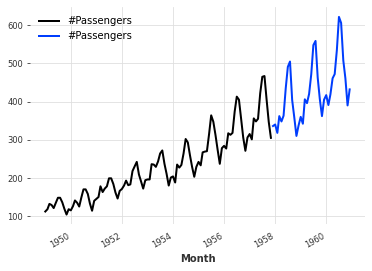

In [5]:
series1, series2 = series.split_before(0.75)
series1.plot()
series2.plot()

## Training Model

#### NaiveSeasonal(k)

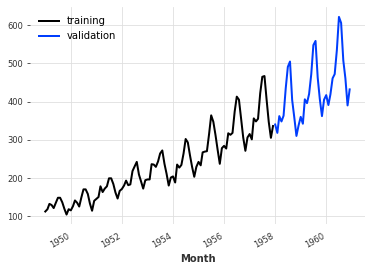

In [6]:
train, val = series.split_before(pd.Timestamp("19580101"))
train.plot(label="training")
val.plot(label="validation")


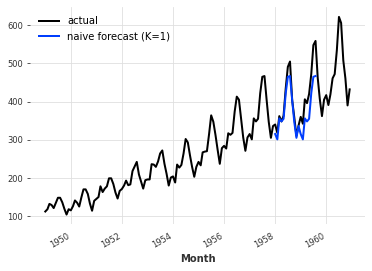

In [7]:

from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=12)
naive_model.fit(train)
naive_forecast = naive_model.predict(20)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

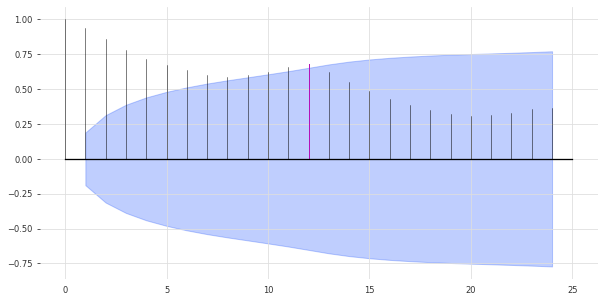

In [8]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=12, alpha=0.05)

In [9]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 12.


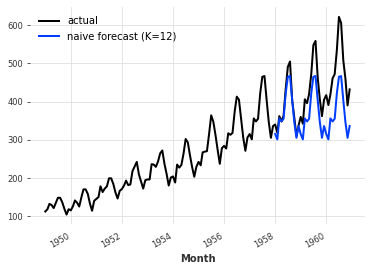

In [10]:
seasonal_model = NaiveSeasonal(K=12)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(36)

series.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=12)")

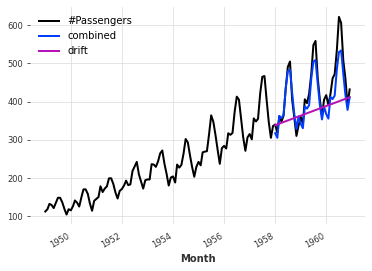

In [11]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(36)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

In [12]:
from darts.metrics import mape

print(
    "Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(
        mape(series, combined_forecast)
    )
)

Mean absolute percentage error for the combined naive drift + seasonal: 5.66%.


## 快速上手其他模型

In [15]:
from darts.models import ExponentialSmoothing, AutoARIMA, Theta


def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))


eval_model(ExponentialSmoothing())
eval_model(AutoARIMA())
eval_model(Theta())

model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12 obtains MAPE: 5.11%
model Auto-ARIMA obtains MAPE: 11.65%
model Theta(2) obtains MAPE: 8.15%


In [18]:
# Search for the best theta parameter, by trying 50 different values
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float("inf")
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta

In [19]:
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print(
    "The MAPE is: {:.2f}, with theta = {}.".format(
        mape(val, pred_best_theta), best_theta
    )
)

The MAPE is: 4.40, with theta = -3.5102040816326543.


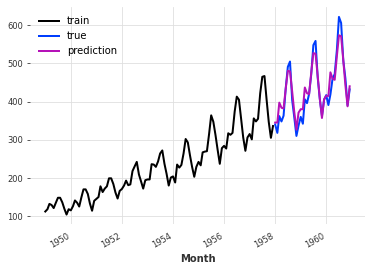

In [20]:
train.plot(label="train")
val.plot(label="true")
pred_best_theta.plot(label="prediction")

  0%|          | 0/57 [00:00<?, ?it/s]

MAPE = 7.70%


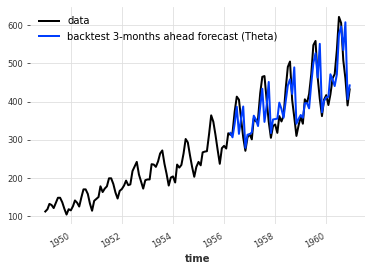

In [21]:
historical_fcast_theta = best_theta_model.historical_forecasts(
    series, start=0.6, forecast_horizon=3, verbose=True
)

series.plot(label="data")
historical_fcast_theta.plot(label="backtest 3-months ahead forecast (Theta)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_theta, series)))

  0%|          | 0/57 [00:00<?, ?it/s]

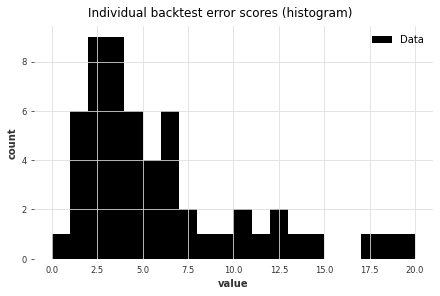

In [22]:
best_theta_model = Theta(best_theta)

raw_errors = best_theta_model.backtest(
    series, start=0.6, forecast_horizon=3, metric=mape, reduction=None, verbose=True
)

from darts.utils.statistics import plot_hist

plot_hist(
    raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    title="Individual backtest error scores (histogram)",
)

In [24]:
average_error = best_theta_model.backtest(
    series,
    start=0.6,
    forecast_horizon=3,
    metric=mape,
    reduction=np.mean,  # this is actually the default
    verbose=True,
)
print("Average error (MAPE) over all historical forecasts: %.2f" % average_error)


  0%|          | 0/57 [00:00<?, ?it/s]

Average error (MAPE) over all historical forecasts: 6.36


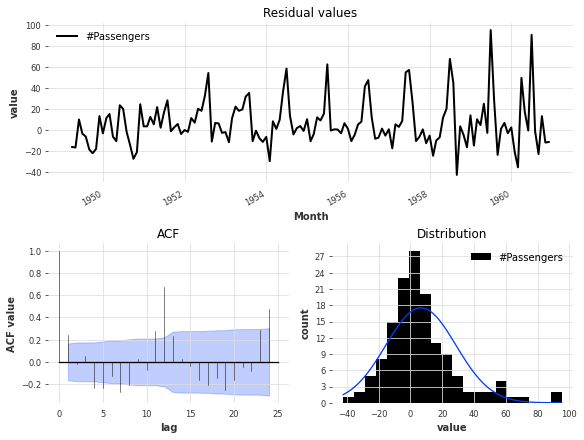

In [25]:
from darts.utils.statistics import plot_residuals_analysis

plot_residuals_analysis(best_theta_model.residuals(series))

  0%|          | 0/57 [00:00<?, ?it/s]

MAPE = 4.45%


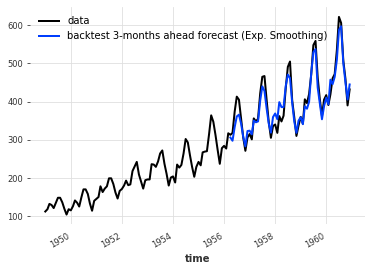

In [26]:
model_es = ExponentialSmoothing()
historical_fcast_es = model_es.historical_forecasts(
    series, start=0.6, forecast_horizon=3, verbose=True
)

series.plot(label="data")
historical_fcast_es.plot(label="backtest 3-months ahead forecast (Exp. Smoothing)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_es, series)))

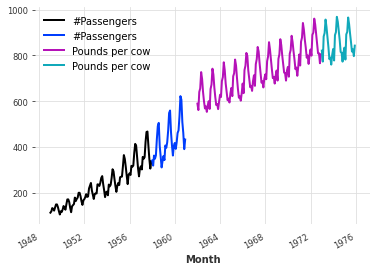

In [28]:
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset

series_air = AirPassengersDataset().load().astype(np.float32)
series_milk = MonthlyMilkDataset().load().astype(np.float32)

# set aside last 36 months of each series as validation set:
train_air, val_air = series_air[:-36], series_air[-36:]
train_milk, val_milk = series_milk[:-36], series_milk[-36:]

train_air.plot()
val_air.plot()
train_milk.plot()
val_milk.plot()

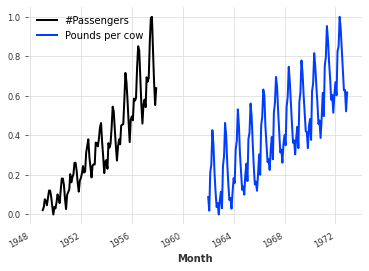

In [30]:
from darts.dataprocessing.transformers import Scaler

scaler = Scaler()
train_air_scaled, train_milk_scaled = scaler.fit_transform([train_air, train_milk])

train_air_scaled.plot()
train_milk_scaled.plot()

In [31]:
from darts.models import NBEATSModel

model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42)
model.fit([train_air_scaled, train_milk_scaled], epochs=50, verbose=True)

[2022-06-12 18:57:13,875] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 194 samples.
[2022-06-12 18:57:13,875] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 194 samples.
2022-06-12 18:57:13 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 194 samples.
[2022-06-12 18:57:13,961] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 32-bits; casting model to float32.
[2022-06-12 18:57:13,961] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 32-bits; casting model to float32.
2022-06-12 18:57:13 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 32-bits; casting model to float32.
[2022-06-12 18:57:13,963] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightnin

Training: 0it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

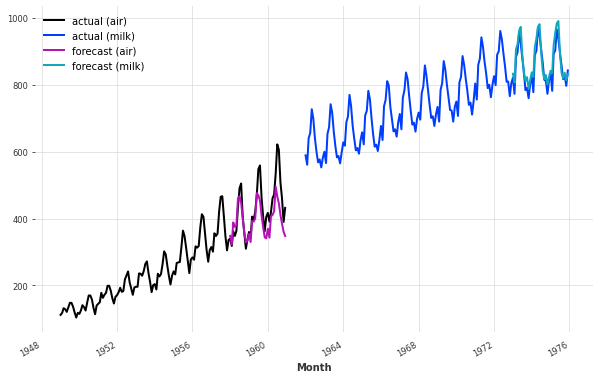

In [32]:
pred_air = model.predict(series=train_air_scaled, n=36)
pred_milk = model.predict(series=train_milk_scaled, n=36)

# scale back:
pred_air, pred_milk = scaler.inverse_transform([pred_air, pred_milk])

plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
series_milk.plot(label="actual (milk)")
pred_air.plot(label="forecast (air)")
pred_milk.plot(label="forecast (milk)")

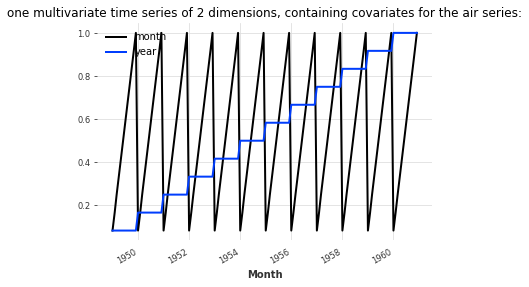

In [33]:
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr

air_covs = concatenate(
    [
        dt_attr(series_air.time_index, "month", dtype=np.float32) / 12,
        (dt_attr(series_air.time_index, "year", dtype=np.float32) - 1948) / 12,
    ],
    axis="component",
)

milk_covs = concatenate(
    [
        dt_attr(series_milk.time_index, "month", dtype=np.float32) / 12,
        (dt_attr(series_milk.time_index, "year", dtype=np.float32) - 1962) / 13,
    ],
    axis="component",
)

air_covs.plot()
plt.title(
    "one multivariate time series of 2 dimensions, containing covariates for the air series:"
);

In [34]:
model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42)

model.fit(
    [train_air_scaled, train_milk_scaled],
    past_covariates=[air_covs, milk_covs],
    epochs=50,
    verbose=True,
)

[2022-06-12 19:09:38,762] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 194 samples.
[2022-06-12 19:09:38,762] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 194 samples.
2022-06-12 19:09:38 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 194 samples.
[2022-06-12 19:09:38,848] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 32-bits; casting model to float32.
[2022-06-12 19:09:38,848] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 32-bits; casting model to float32.
2022-06-12 19:09:38 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 32-bits; casting model to float32.
[2022-06-12 19:09:38,851] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightnin

Training: 0it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

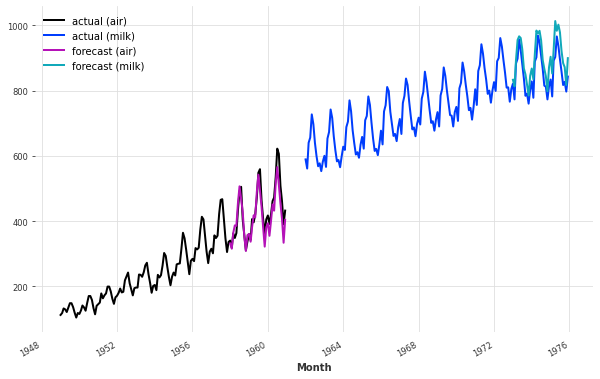

In [35]:
pred_air = model.predict(series=train_air_scaled, past_covariates=air_covs, n=36)
pred_milk = model.predict(series=train_milk_scaled, past_covariates=milk_covs, n=36)

# scale back:
pred_air, pred_milk = scaler.inverse_transform([pred_air, pred_milk])

plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
series_milk.plot(label="actual (milk)")
pred_air.plot(label="forecast (air)")
pred_milk.plot(label="forecast (milk)")

In [36]:
# encoders = {
#     "cyclic": {"future": ["month"]},
#     "datetime_attribute": {"future": ["hour", "dayofweek"]},
#     "position": {"past": ["absolute"], "future": ["relative"]},
#     "custom": {"past": [lambda idx: (idx.year - 1950) / 50]},
#     "transformer": Scaler(),
# }

In [37]:
encoders = {"datetime_attribute": {"past": ["month", "year"]}, "transformer": Scaler()}

<TimeSeries (DataArray) (Month: 108, component: 1, sample: 1)>
array([[[0.02203858]],

       [[0.03856748]],

       [[0.077135  ]],

       [[0.06887051]],

       [[0.04683197]],

       [[0.08539945]],

       [[0.12121212]],

       [[0.12121212]],

       [[0.08815429]],

       [[0.04132232]],

...

       [[0.69421494]],

       [[0.67217636]],

       [[0.69146   ]],

       [[0.87603307]],

       [[0.9944904 ]],

       [[1.        ]],

       [[0.8264463 ]],

       [[0.66942155]],

       [[0.55371904]],

       [[0.63911843]]], dtype=float32)
Coordinates:
  * Month      (Month) datetime64[ns] 1949-01-01 1949-02-01 ... 1957-12-01
  * component  (component) object '#Passengers'
Dimensions without coordinates: sample

In [39]:
model = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=12,
    add_encoders=encoders,
    random_state=42,
)

model.fit([train_air_scaled, train_milk_scaled], epochs=50, verbose=True)

[2022-06-12 19:14:57,028] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 194 samples.
[2022-06-12 19:14:57,028] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 194 samples.
2022-06-12 19:14:57 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 194 samples.
[2022-06-12 19:14:57,109] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 32-bits; casting model to float32.
[2022-06-12 19:14:57,109] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 32-bits; casting model to float32.
2022-06-12 19:14:57 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 32-bits; casting model to float32.
[2022-06-12 19:14:57,112] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightnin

Training: 0it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

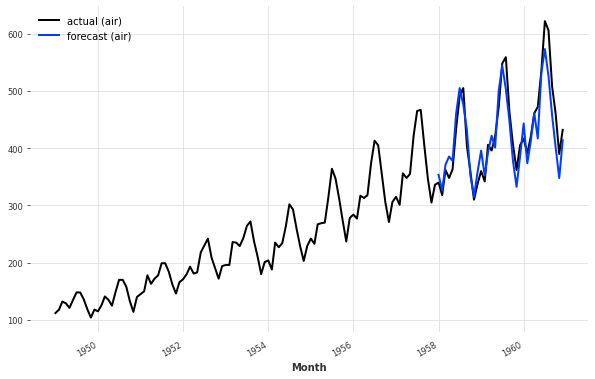

In [40]:
pred_air = model.predict(series=train_air_scaled, n=36)

# scale back:
pred_air = scaler.inverse_transform(pred_air)

plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
pred_air.plot(label="forecast (air)")

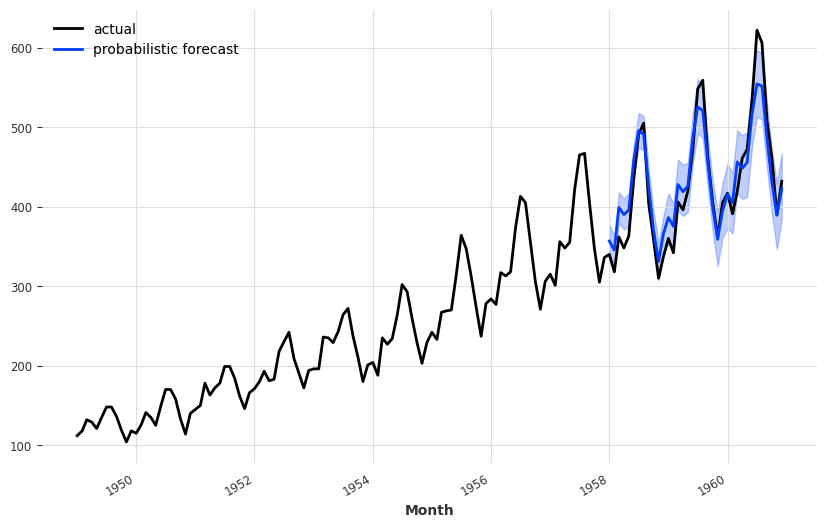

In [47]:
model_es = ExponentialSmoothing()
model_es.fit(train)
probabilistic_forecast = model_es.predict(len(val), num_samples=500)

plt.figure(figsize=(10, 6), dpi=100)
series.plot(label="actual")
probabilistic_forecast.plot(label="probabilistic forecast")
plt.legend()
plt.show()